In [1]:
from inlaw.nb_util import setup_nb
setup_nb()

In [2]:
import inlaw.inla as inla
import inlaw.quad as quad
import inlaw.berry as berry
import numpy as np
from numpy import nan
import jax
import jax.numpy as jnp

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1) Set up the data and problem, hyperparam posterior
n_arms = 4
data = berry.figure2_data(1)[:, :n_arms]
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)
sig2 = sig2_rule.pts
p_ex = dict(sig2=np.array([nan]), theta=np.zeros(n_arms))
ad_ops = inla.from_log_joint(berry.log_joint(n_arms), p_ex)
p_pinned = dict(sig2=sig2, theta=None)
_, x_max, hess, _ = jax.jit(
    jax.vmap(ad_ops.hyper_logpost, in_axes=(None, None, 0))
)(np.zeros((15, n_arms)), p_pinned, data)


In [4]:

arm_idx = 0
theta_arm_ex = np.zeros(4)
theta_arm_ex[arm_idx] = nan
arm_ex = dict(sig2=np.array([nan]), theta=theta_arm_ex)
ad_arm_ops = inla.from_log_joint(berry.log_joint (n_arms), arm_ex)

inv_hess = jnp.linalg.inv(hess)
cx, wts = inla.gauss_hermite_grid(x_max, inv_hess[:, :, arm_idx], arm_idx, n=25)


lm_fnc = jax.jit(
    jax.vmap(
        jax.vmap(ad_ops.latent_logpost, in_axes=(0, 0, None, 0, 0, None)),
        in_axes=(None, None, None, None, 0, None),
    ),
    static_argnums=(5,),
)
logpost_arm = lm_fnc(x_max, inv_hess[:, :, arm_idx], p_pinned, data, cx, arm_idx)
arm_marg = inla.exp_and_normalize(logpost_arm, wts, axis=0)

In [5]:

# Step 2) Arm marginals from the automatic differentiation version
arm_idx = 0
theta_arm_ex = np.zeros(4)
theta_arm_ex[arm_idx] = nan
arm_ex = dict(sig2=np.array([nan]), theta=theta_arm_ex)
ad_arm_ops = inla.from_log_joint(berry.log_joint (n_arms), arm_ex)

inv_hess = jnp.linalg.inv(hess)
cx, wts = inla.gauss_hermite_grid(x_max, inv_hess[:, :, arm_idx], arm_idx, n=25)

sig2_tiled = np.tile(sig2[None, None, :], (cx.shape[0], data.shape[0], 1))
theta_fixed = np.full((*sig2_tiled.shape, 4), nan)
theta_fixed[..., arm_idx] = cx
arm_pinned = dict(sig2=sig2_tiled, theta=theta_fixed)

x0 = x_max[..., 1:]

In [6]:
cond_mu_f = jax.jit(
    jax.vmap(
        jax.vmap(inla.mvn_conditional_meanv, in_axes=(0, 0, 0, None)),
        in_axes=(None, None, 0, None),
    )
)
integrate_f = jax.jit(jax.vmap(jax.vmap(ad_arm_ops.integrate_cond_gaussian, in_axes=(0,0,0,0)), in_axes=(0,0,0, None)))
cond_mu = cond_mu_f(x_max, inv_hess[:, :, arm_idx], cx, arm_idx)
cond_mu = np.delete(cond_mu, arm_idx, axis=-1)
cond_hess_f = jax.jit(jax.vmap(jax.vmap(ad_arm_ops.hessv, in_axes=(0, 0, 0)), in_axes=(0, 0, None)))
cond_hess = cond_hess_f(cond_mu, arm_pinned, data)
logpost_arm2 = integrate_f(cond_mu, cond_hess, arm_pinned, data)
arm_marg2 = inla.exp_and_normalize(logpost_arm2, wts, axis=0)

In [27]:
x_max.shape, inv_hess.shape, 

((1, 15, 4), (1, 15, 4, 4))

In [34]:
cond_laplace_f = jax.jit(
    jax.vmap(
        jax.vmap(ad_arm_ops.cond_laplace_logpost, in_axes=(0, 0, 0, 0, 0, None)),
        in_axes=(None, None, 0, None, 0, None),
    ),
    static_argnums=(5,),
)
logpost_arm2 = cond_laplace_f(x_max, inv_hess[:,:,arm_idx], arm_pinned, data, cx, arm_idx)
arm_marg2 = inla.exp_and_normalize(logpost_arm2, wts, axis=0)

In [35]:
laplace_f = jax.jit(jax.vmap(jax.vmap(ad_arm_ops.laplace_logpost, in_axes=(0, 0, 0)), in_axes=(None, 0, None)))

In [46]:
%%time
logpost_arm, arm_x_max, arm_hess, arm_iters = laplace_f(x_max[..., 1:], arm_pinned, data)
arm_marg = inla.exp_and_normalize(logpost_arm, wts, axis=0)

CPU times: user 1.05 ms, sys: 512 µs, total: 1.56 ms
Wall time: 984 µs


In [47]:
for sig_idx in range(15):
    print(np.max(np.abs(arm_marg[:, 0, sig_idx] - arm_marg2[:, 0, sig_idx])))

2.573119894933029e-07
4.351911115918483e-07
1.0950173485735348e-06
3.946506847318787e-06
1.9289714066061947e-05
0.00011800408438622512
0.0007477173564647277
0.00232622063234178
0.0010426009339009612
0.0003996625703202583
9.672989274039923e-05
1.1558799448918577e-05
1.1255796386264172e-06
1.2841080808401184e-07
3.158566853206368e-08


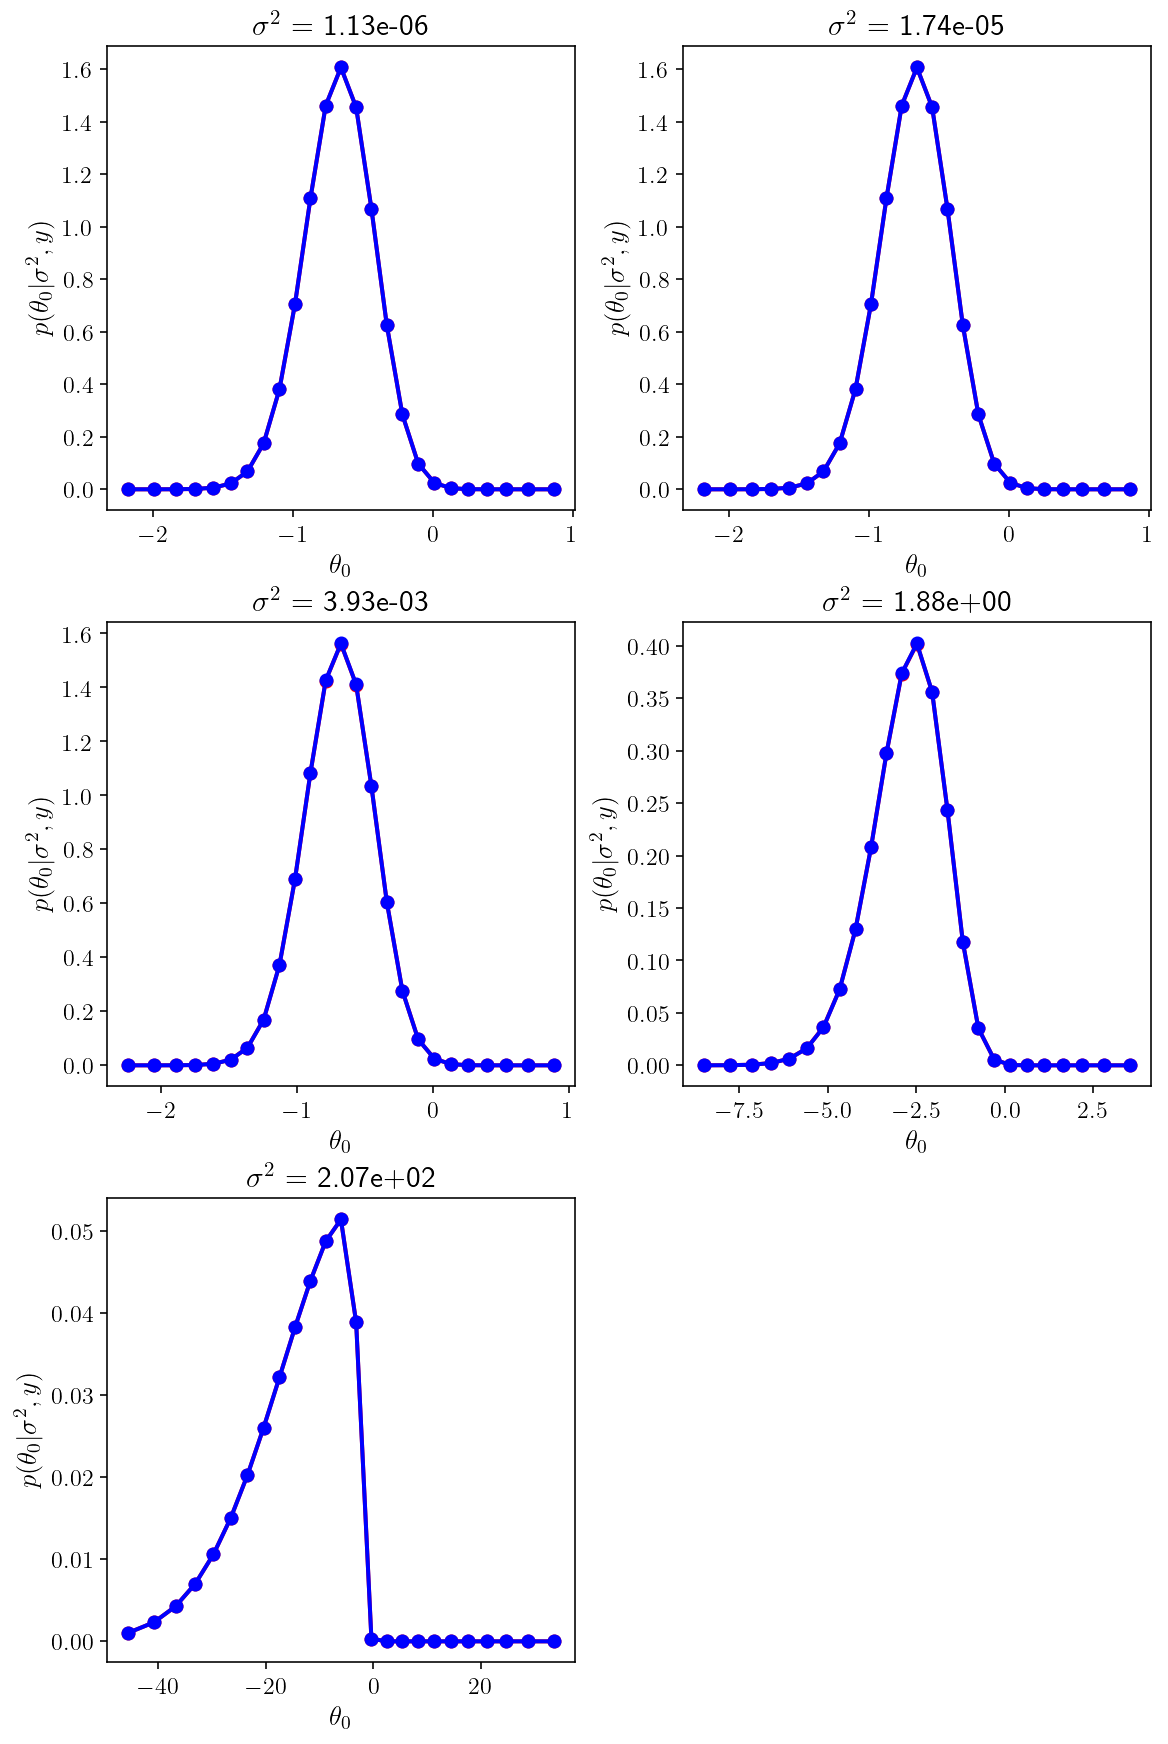

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 12), constrained_layout=True)
for j, sig_idx in enumerate(range(15)[::3]):
    plt.subplot(3, 2, 1 + j)
    plt.title(f"$\sigma^2$ = {sig2_rule.pts[sig_idx]:5.2e}")
    plt.plot(cx[:, 0, sig_idx], arm_marg[:, 0, sig_idx], "r-o", linewidth=2.0)
    plt.plot(cx[:, 0, sig_idx], arm_marg2[:, 0, sig_idx], "b-o", linewidth=2.0)
    plt.ylabel(r'$p(\theta_0 | \sigma^2, y)$')
    plt.xlabel(r'$\theta_0$')
    # plt.hist(mcmc_arm, bins=np.linspace(*window, 40), density=True)
plt.show()
